# <div align="center">Data Science with Stock Data - Logistic Regression</div>
### <div align="center">Author: <a href="https://www.linkedin.com/in/kaming-yip-22b03a1a0/">Kaming Yip</a>&emsp;&emsp;Date: Mar. 3, 2020</div>

Before start reading this file, you are suggested to read the project instruction in the <a href="https://github.com/KamingYip/Data-Science-with-Stock-Data/blob/master/README.md">README.md</a> file.

In this file, we will implement <b>Logistic Regression</b> in our selected stock data, YELP, for two years 2018 and 2019, to predict labels and compute the model performance of trading strategies based on the labels.

Logistic Regression is a supervised learning classification algorithm used to predict the probability of a target variable by sigmoid function.

First, we scrape the historical data from <a href="https://finance.yahoo.com/quote/YELP?p=YELP&.tsrc=fin-srch-v1">yahoo web</a> and manipulate the data to create desirable columns.

In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np

In [2]:
def get_stock(ticker, start_date, end_date):
    try:
        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Return'] = 100.0 * df['Return']
        df['Return'] = df['Return'].round(3)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.weekday_name  
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 'Week_Number', 'Year_Week',
                    'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Return']
        df = df[col_list]
        return df
    except Exception as error:
        print(error)
        return None

ticker='YELP'
df = get_stock(ticker, start_date='2017-01-01', end_date='2019-12-31')
df.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return
Date,,,,,,,,,,,,,,
2017-01-03,2017-01-03,2017,1,3,Tuesday,01,2017-01,38.50,39.14,37.56,38.22,2391900,38.22,0.000
2017-01-04,2017-01-04,2017,1,4,Wednesday,01,2017-01,38.28,39.44,38.28,39.42,2238000,39.42,3.140
2017-01-05,2017-01-05,2017,1,5,Thursday,01,2017-01,39.20,40.18,38.81,39.62,2310900,39.62,0.507
2017-01-06,2017-01-06,2017,1,6,Friday,01,2017-01,39.80,39.96,39.21,39.31,1230200,39.31,-0.782
2017-01-09,2017-01-09,2017,1,9,Monday,02,2017-02,39.49,40.41,39.31,40.14,1719000,40.14,2.111


Then we will create the mean return and volatility values for each week. These two features will be our main independent variables to train the model.

In [3]:
def weekly_return_volatility(data, start_date, end_date):
    df_2 = data[data['Date'] >= start_date]
    df_2 = df_2[df_2['Date'] <= end_date]
    df_2 = df_2[['Year', 'Week_Number', 'Open', 'Adj Close', 'Return']]
    df_2.index = range(len(df_2))
    df_grouped = df_2.groupby(['Year', 'Week_Number'])['Return'].agg([np.mean, np.std])
    df_grouped.reset_index(['Year', 'Week_Number'], inplace=True)
    df_grouped.rename(columns={'mean': 'mean_return', 'std':'volatility'}, inplace=True)
    df_grouped.fillna(0, inplace=True)
    df_grouped["Open"] = df_2.groupby(["Year", "Week_Number"])["Open"].head(1).\
                                      reset_index(drop = True).copy()
    df_grouped["Adj Close"] = df_2.groupby(["Year", "Week_Number"])["Adj Close"].tail(1).\
                                           reset_index(drop = True).copy()
    return df_grouped

df_weekly = weekly_return_volatility(df, start_date='2018-01-01', end_date='2019-12-31')
df_weekly.head()

,Year,Week_Number,mean_return,volatility,Open,Adj Close
0,2018,00,0.7235,1.677695,42.06,43.17
1,2018,01,1.0174,1.548486,43.03,45.39
2,2018,02,-1.4135,2.049766,45.39,42.85
3,2018,03,0.6000,1.871186,42.70,44.12
4,2018,04,0.3262,2.706359,44.06,44.78


For each week, we will label as "green" or "red":
* a "green" week means that it was a good week to be invested for that week (from Friday to Friday)
* a "red" week means that it was <b>NOT</b> a good week (e.g. prices fell or there was too much volatility in the price)

In this project, we will label those weeks with mean return higher than or equal to the 50-percentile threshold as well as with volatility not higher than the 50-percentile threshold of that year as "Green"; otherwise, they will be labeled as "Red".

In [4]:
def weekly_label(data, year):
    df_label = data[data["Year"] == year].copy()
    mean_return_percent50 = np.percentile(df_label["mean_return"], 50)
    volatility_percent50 = np.percentile(df_label["volatility"], 50)      
    df_label["True Label"] = np.where((df_label["mean_return"] >= mean_return_percent50) & \
                                      (df_label["volatility"] <= volatility_percent50), "Green", "Red")
    return df_label

df_labeling = pd.DataFrame()
for year in [2018, 2019]:
    df_year_label = weekly_label(df_weekly, year)
    label_count = df_year_label.groupby("True Label")["True Label"].size().to_frame(name = "Freq")       
    df_labeling = df_labeling.append(df_year_label, ignore_index = True)

df_labeling.head()

,Year,Week_Number,mean_return,volatility,Open,Adj Close,True Label
0,2018,00,0.7235,1.677695,42.06,43.17,Green
1,2018,01,1.0174,1.548486,43.03,45.39,Green
2,2018,02,-1.4135,2.049766,45.39,42.85,Red
3,2018,03,0.6000,1.871186,42.70,44.12,Red
4,2018,04,0.3262,2.706359,44.06,44.78,Red


Let's take a look at the label distribution in training data and testing data.

In [5]:
train_df = df_labeling[df_labeling["Year"] == 2018].copy()
test_df = df_labeling[df_labeling["Year"] == 2019].copy()

train_test_sum = pd.DataFrame({
    "Dataset": ["Training", "Testing", "Total"],
    "Week Num": ["{0:,}({1:.2f}%)".format(len(train_df), len(train_df)/len(df_labeling)*100),
                 "{0:,}({1:.2f}%)".format(len(test_df), len(test_df)/len(df_labeling)*100),
                 "{0:,}({1:.2f}%)".format(len(df_labeling), len(df_labeling)/len(df_labeling)*100)],
    "Green Label": ["{0:,}({1:.2f}%)".format(len(train_df[train_df["True Label"] == "Green"]),
                                             len(train_df[train_df["True Label"] == "Green"])/len(train_df)*100),
                    "{0:,}({1:.2f}%)".format(len(test_df[test_df["True Label"] == "Green"]),
                                             len(test_df[test_df["True Label"] == "Green"])/len(test_df)*100),
                    "{0:,}({1:.2f}%)".format(len(df_labeling[df_labeling["True Label"] == "Green"]),
                                             len(df_labeling[df_labeling["True Label"] == "Green"])/len(df_labeling)*100)],
    "Red Label": ["{0:,}({1:.2f}%)".format(len(train_df[train_df["True Label"] == "Red"]),
                                           len(train_df[train_df["True Label"] == "Red"])/len(train_df)*100),
                  "{0:,}({1:.2f}%)".format(len(test_df[test_df["True Label"] == "Red"]),
                                           len(test_df[test_df["True Label"] == "Red"])/len(test_df)*100),
                  "{0:,}({1:.2f}%)".format(len(df_labeling[df_labeling["True Label"] == "Red"]),
                                           len(df_labeling[df_labeling["True Label"] == "Red"])/len(df_labeling)*100)]})

train_test_sum

,Dataset,Week Num,Green Label,Red Label
0,Training,53(50.00%),16(30.19%),37(69.81%)
1,Testing,53(50.00%),14(26.42%),39(73.58%)
2,Total,106(100.00%),30(28.30%),76(71.70%)


By far, we have completed the data preparation. From the raw data, we have conducted feature engineering to create new features that we would use in the modeling, calculated the average return and volatility for each week, and labeled each week as "Green" or "Red" by a predetermined rule. We will then use the labeled dataset in the following sections.

We will first define our confusion matrix function to better visualize the model performance, including Accuracy, Recall, Precision, and F1 score.

In [6]:
from tabulate import tabulate
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [7]:
def designed_confusion_matrix(train_actual, train_pred, train_title,
                              test_actual, test_pred, test_title, classes):
    fig = plt.figure(figsize = (8, 5))
            
    fig.add_subplot(221)
    train_cm = confusion_matrix(train_actual, train_pred)
    plt.imshow(train_cm, interpolation = "nearest", cmap = "Reds")
    plt.title(train_title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
        plt.text(j, i, format(train_cm[i, j], "d"), horizontalalignment = "center", color = "black")
    plt.tight_layout()
    plt.ylabel("Actual Class")      
    plt.xlabel("Predicted Class")
            
    fig.add_subplot(222)
    test_cm = confusion_matrix(test_actual, test_pred)
    plt.imshow(test_cm, interpolation = "nearest", cmap = "Reds")
    plt.title(test_title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
        plt.text(j, i, format(test_cm[i, j], "d"), horizontalalignment = "center", color = "black")
    plt.tight_layout()
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    plt.show()
            
    stats_summary = pd.DataFrame(columns = ["Training Data", "Testing Data"],
                                 index = ["Accuracy", "Recall", "Precision", "F1 Score"])
    stats_set = [[train_actual, train_pred], [test_actual, test_pred]]
    for i, ele in enumerate(stats_set):
        stats_summary.iloc[:, i] = [accuracy_score(ele[0], ele[1]),
                                    recall_score(ele[0], ele[1], pos_label = classes[0]),
                                    precision_score(ele[0], ele[1], pos_label = classes[0]),
                                    f1_score(ele[0], ele[1], pos_label = classes[0])]
    print(tabulate(stats_summary, headers = "keys", numalign = "right", floatfmt = ".3f"), end = "\n\n")

The Logistic Regression model will be trained by stock data in 2018 and computed the accuracy of the Logistic Regression classifier.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [9]:
X_train = train_df[["mean_return", "volatility"]].values
LogReg_scaler = StandardScaler().fit(X_train)
X_train = LogReg_scaler.transform(X_train)
y_train = train_df["True Label"].values

X_test = test_df[["mean_return", "volatility"]].values
X_test = LogReg_scaler.transform(X_test)
y_test = test_df["True Label"].values

In [10]:
LogReg_classifier = LogisticRegression(solver = "lbfgs")
LogReg_classifier.fit(X_train, y_train)
y_train_pred = LogReg_classifier.predict(X_train)
y_test_pred = LogReg_classifier.predict(X_test)
mean_return_coef = LogReg_classifier.coef_[0][0]
volatility_coef = LogReg_classifier.coef_[0][1]
intercept = LogReg_classifier.intercept_[0]
print("The equation for the weighted output is:\ny = ({0:.3f}) + ({1:.3f}) * mean_return + ({2:.3f}) * volatility".\
      format(intercept, mean_return_coef, volatility_coef),
      "The sigmoid function for the Logistic Regression model is:\nz(y) = 1 / (1 + exp(-y))", sep = "\n\n")

The equation for the weighted output is:
y = (1.499) + (-1.399) * mean_return + (2.140) * volatility

The sigmoid function for the Logistic Regression model is:
z(y) = 1 / (1 + exp(-y))


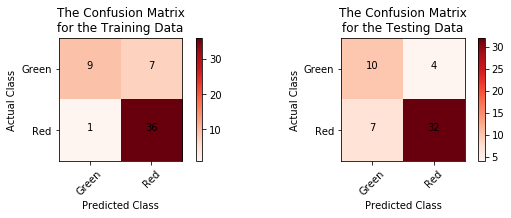

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.849           0.792
Recall               0.562           0.714
Precision            0.900           0.588
F1 Score             0.692           0.645



In [11]:
designed_confusion_matrix(y_train, y_train_pred, "The Confusion Matrix\nfor the Training Data",
                          y_test, y_test_pred, "The Confusion Matrix\nfor the Testing Data",
                          ["Green", "Red"])

The accuracy of the Logistic Regression model when it predicts the labels for training data is 84.9% and the F1 score is 0.692, while the accuracy of the model against testing data is 79.2% with a F1 score as 0.645.

Then, we will implement the trading strategy suggested by the model and compare its performance to the other trading straties.

In [12]:
def trade_with_labels(data, col_name):
    money = 100.0
    shares = 0.0
    position = "No"
    balance = []
    df_trade_labels = data.copy()
    for i in range(len(df_trade_labels) - 1):
        if i == 0:
            label = df_trade_labels.iloc[i][col_name]
            if label == "Green":
                shares = money / df_trade_labels.iloc[i]["Open"]
                money = 0.0
                position = "Long"
                balance.append(shares * df_trade_labels.iloc[i]["Adj Close"])
            else:
                balance.append(money)              
        else:
            label = df_trade_labels.iloc[i+1][col_name]
            if label == "Red":
                if position == "Long":
                    money = shares * df_trade_labels.iloc[i]["Adj Close"]
                    shares = 0.0
                    position = "No"
                balance.append(money)
            else:
                if position == "No":
                    shares = money / df_trade_labels.iloc[i+1]["Open"]
                    money = 0.0
                    position = "Long"
                balance.append(shares * df_trade_labels.iloc[i]["Adj Close"])            
    if position == "Long":
        balance.append(shares * df_trade_labels.iloc[-1]["Adj Close"])
    else:
        balance.append(money)
    return balance

def script_text(data, year, col_name):
    label_text_max = "{0} Week {1}\nmax ${2}".\
                     format(year, data.iloc[data[data["Year"] == year][col_name].idxmax()]["Week_Number"],
                            round(data[data["Year"] == year][col_name].max(), 2))
    label_x_max = data[data["Year"] == year][col_name].idxmax()
    label_y_max = round(data[data["Year"] == year][col_name].max(), 2)
            
    label_text_min = "{0} Week {1}\nmin ${2}".\
                     format(year,
                            data.iloc[data[data["Year"] == year][col_name].idxmin()]["Week_Number"],
                            round(data[data["Year"] == year][col_name].min(), 2))
    label_x_min = data[data["Year"] == year][col_name].idxmin()
    label_y_min = round(data[data["Year"] == year][col_name].min(), 2)
            
    label_text_final = "{0} Final:\n${1}".format(year, round(data[data["Year"] == year].iloc[-1][col_name], 2))
    label_x_final = data[data["Year"] == year].tail(1).index.values
    label_y_final = round(data[data["Year"] == year].iloc[-1][col_name], 2)
       
    return label_text_max, label_x_max, label_y_max,\
           label_text_min, label_x_min, label_y_min,\
           label_text_final, label_x_final, label_y_final

def buy_n_hold(data):
    money = 100.0
    shares = 0.0
    balance = []
    df_buy_hold = data.copy()  
    for i in range(len(df_buy_hold)):
        if i == 0:
            shares = money / df_buy_hold.iloc[i]["Open"]
        balance.append(shares * df_buy_hold.iloc[i]["Adj Close"])
    return balance

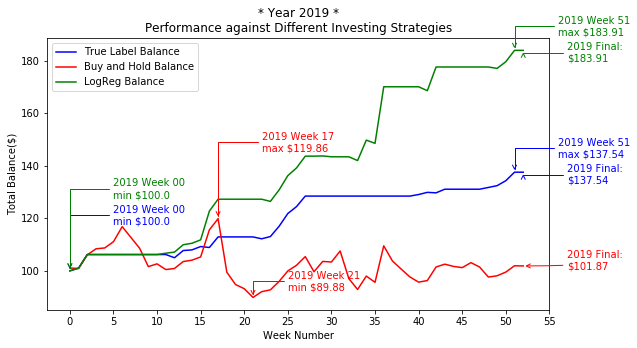

In [13]:
df_trading = df_labeling[df_labeling["Year"] == 2019].copy().reset_index(drop = True)
df_trading["True Label Balance"] = trade_with_labels(df_trading, "True Label")
df_trading["Buy and Hold Balance"] = buy_n_hold(df_trading)

df_trading["LogReg Label"] = y_test_pred
df_trading["LogReg Balance"] = trade_with_labels(df_trading, "LogReg Label")

fig, ax = plt.subplots(figsize = (9, 5))
       
label_text_max_2019, label_x_max_2019, label_y_max_2019,\
    label_text_min_2019, label_x_min_2019, label_y_min_2019,\
        label_text_final_2019, label_x_final_2019, label_y_final_2019 =\
            script_text(df_trading, 2019, "True Label Balance")
        
buy_hold_text_max_2019, buy_hold_x_max_2019, buy_hold_y_max_2019,\
    buy_hold_text_min_2019, buy_hold_x_min_2019, buy_hold_y_min_2019,\
        buy_hold_text_final_2019, buy_hold_x_final_2019, buy_hold_y_final_2019 =\
            script_text(df_trading, 2019, "Buy and Hold Balance")
        
log_text_max_2019, log_x_max_2019, log_y_max_2019,\
    log_text_min_2019, log_x_min_2019, log_y_min_2019,\
        log_text_final_2019, log_x_final_2019, log_y_final_2019 =\
            script_text(df_trading, 2019, "LogReg Balance")

# Trading with True Labels
ax.plot(df_trading.index, "True Label Balance", data = df_trading, color = "blue")
        
ax.annotate(label_text_max_2019, xy = (label_x_max_2019, label_y_max_2019), xycoords = "data",
            xytext = (label_x_max_2019+5, label_y_max_2019+5), color = "blue",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "blue"),
            ha = "left", va = "bottom")
ax.annotate(label_text_min_2019, xy = (label_x_min_2019, label_y_min_2019), xycoords = "data",
            xytext = (label_x_min_2019+5, label_y_min_2019+17), color = "blue",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "blue"),
            ha = "left", va = "bottom")
ax.annotate(label_text_final_2019, xy = (label_x_final_2019, label_y_final_2019), xycoords = "data",
            xytext = (label_x_final_2019+5, label_y_final_2019-5), color = "blue",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "blue"),
            ha = "left", va = "bottom")
        
# Buy and Hold
ax.plot(df_trading.index, "Buy and Hold Balance", data = df_trading, color = "red")
        
ax.annotate(buy_hold_text_max_2019, xy = (buy_hold_x_max_2019, buy_hold_y_max_2019), xycoords = "data",
            xytext = (buy_hold_x_max_2019+5, buy_hold_y_max_2019+25), color = "red",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "red"),
            ha = "left", va = "bottom")
ax.annotate(buy_hold_text_min_2019, xy = (buy_hold_x_min_2019, buy_hold_y_min_2019), xycoords = "data",
            xytext = (buy_hold_x_min_2019+4, buy_hold_y_min_2019+2), color = "red",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "red"),
            ha = "left", va = "bottom")
ax.annotate(buy_hold_text_final_2019, xy = (buy_hold_x_final_2019, buy_hold_y_final_2019), xycoords = "data",
            xytext = (buy_hold_x_final_2019+5, buy_hold_y_final_2019-2), color = "red",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle3", color = "red"),
            ha = "left", va = "bottom")
        
# Logistic Regression Labels
ax.plot(df_trading.index, "LogReg Balance", data = df_trading, color = "green")
        
ax.annotate(log_text_max_2019, xy = (log_x_max_2019, log_y_max_2019), xycoords = "data",
            xytext = (log_x_max_2019+5, log_y_max_2019+5), color = "green",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "green"),
            ha = "left", va = "bottom")
ax.annotate(log_text_min_2019, xy = (log_x_min_2019, log_y_min_2019), xycoords = "data",
            xytext = (log_x_min_2019+5, log_y_min_2019+27), color = "green",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "green"),
            ha = "left", va = "bottom")
ax.annotate(log_text_final_2019, xy = (log_x_final_2019, log_y_final_2019), xycoords = "data",
            xytext = (log_x_final_2019+5, log_y_final_2019-5), color = "green",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "green"),
            ha = "left", va = "bottom")

plt.title("* Year 2019 *\n" + "Performance against Different Investing Strategies", loc = "center")
plt.xlabel("Week Number")
plt.xticks(np.arange(0, 60, 5))
plt.ylabel("Total Balance($)")
plt.legend()
plt.show()

As displayed in the plot above, the trading strategy suggested by Logistic Regression model results in the largest amount as $183.91 at the end of year 2019 if we start with $100 investment at the beginning of that year.

The buy-and-hold strategy refers that, if we invest the same amount of money on the first trading day (at the opening price) and sell at the last trading day of the year at the adjusted closing price, we will end up with $101.87, almost the same as the initial investment.

Lastly, if we trade with the true labels, we can earn $137.54 at the end.

By analyzing the differences between the three strategies, we can easily find out that the Logistic Regression suggests several trading labels, which the model applies what it has learnt from the training data (stock data in 2018) to the testing data (stock data in 2019), differently against the true label. By means of that, the regression model benefits from its own decisions and invests based on that. Although there are a few more fluctuations occurred in the trading strategy provided by the Logistic Regression model, it is generally more profitable than the other two strategies, which we are certainly happy to see the results.